In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 7.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [62]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from math import log
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy import sparse as sp
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import scale
from sklearn.utils.validation import check_array, check_consistent_length
from sklearn.utils import check_random_state
from sklearn.utils.fixes import _astype_copy_false
from sklearn.utils.validation import check_array, check_X_y
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils.multiclass import check_classification_targets
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from scipy import special, stats
from scipy.sparse import issparse
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import (as_float_array, check_array, check_X_y, safe_sqr,safe_mask)
from sklearn.utils.extmath import safe_sparse_dot, row_norms
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.feature_selection._base import SelectorMixin
from sklearn.metrics import roc_auc_score
from scipy.sparse import issparse
from scipy.special import digamma
import scipy.stats as stats
from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [53]:

def check_clusterings(labels_true, labels_pred):
    labels_true = check_array(
        labels_true, ensure_2d=False, ensure_min_samples=0, dtype=None,
    )
    labels_pred = check_array(
        labels_pred, ensure_2d=False, ensure_min_samples=0, dtype=None,
    )

    # input checks
    if labels_true.ndim != 1:
        raise ValueError(
            "labels_true must be 1D: shape is %r" % (labels_true.shape,))
    if labels_pred.ndim != 1:
        raise ValueError(
            "labels_pred must be 1D: shape is %r" % (labels_pred.shape,))
    check_consistent_length(labels_true, labels_pred)

    return labels_true, labels_pred

In [59]:
def contingency_matrix(labels_true, labels_pred, *, eps=None, sparse=False):
    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]
    contingency = sp.coo_matrix((np.ones(class_idx.shape[0]),
                                 (class_idx, cluster_idx)),
                                shape=(n_classes, n_clusters),
                                dtype=np.int)
    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
    else:
        contingency = contingency.toarray()
        if eps is not None:
            contingency = contingency + eps
    return contingency

In [26]:
#importing dataset
df = pd.read_csv('DLBCL.tab', delimiter='\t')
df.shape

(79, 7071)

In [27]:
df.head()

,A28102,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,AB000466_at,AB000467_at,AB000468_at,AB000584_at,AB000895_at,AB000896_at,AB000897_at,AB000905_at,AB001106_at,AB001325_at,AB002314_at,AB002315_at,AB002318_at,AB002365_at,AB002366_at,AB002380_at,AB002382_at,AB002409_at,AB002559_at,AB003102_at,AB003103_at,AB003177_at,AB003698_at,AB004884_at,AB006190_at,AC000061_cds2_at,AC000061_cds3_at,AC000062_at,AC000064_cds1_at,AC000064_cds2_at,...,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,class
0,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,...,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,DLBCL FL
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class
2,-1,-45,176,97,-57,233,265,945,56,819,-526,-1075,569,-501,-185,-28,-132,77,564,897,-40,169,1277,-80,-20,117,684,-6,500,864,109,838,332,762,548,368,-51,48,231,102,...,357,69,233,371,-92,21210,13993,1645,354,-341,12542,8233,298,11319,-72,229,778,16,409,41,111,234,354,71,286,575,-210,-1468,165,132,1036,-161,1523,-72,897,366,3,76,-28,DLBCL
3,25,-17,531,353,122,155,209,1688,42,639,-368,-253,892,71,157,-101,-68,136,562,623,4,278,956,193,17,344,768,226,390,912,223,904,270,668,619,248,-59,-18,153,73,...,7216,-27,333,287,-31,7490,15232,411,272,258,17542,14754,270,5700,-136,48,346,13,338,2,708,185,363,221,176,409,-262,-2333,2076,147,4254,-75,6056,-68,737,81,-4,41,-45,DLBCL
4,73,91,257,80,614,507,760,2252,196,863,-618,-596,1963,-226,-237,-133,29,116,999,861,55,539,1245,44,-2,224,597,275,1270,1976,320,1171,479,986,762,412,-65,22,424,115,...,5885,84,237,400,281,24760,14082,384,233,28,13338,15725,433,9175,-273,96,335,-31,318,35,453,112,263,266,299,630,-399,-2024,1468,169,1934,-129,2901,-9,946,450,38,164,-62,DLBCL


In [28]:
df=df.dropna().loc[1:,:]

In [29]:
X = df.drop(['class'], axis=1)
X.head()

,A28102,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,AB000466_at,AB000467_at,AB000468_at,AB000584_at,AB000895_at,AB000896_at,AB000897_at,AB000905_at,AB001106_at,AB001325_at,AB002314_at,AB002315_at,AB002318_at,AB002365_at,AB002366_at,AB002380_at,AB002382_at,AB002409_at,AB002559_at,AB003102_at,AB003103_at,AB003177_at,AB003698_at,AB004884_at,AB006190_at,AC000061_cds2_at,AC000061_cds3_at,AC000062_at,AC000064_cds1_at,AC000064_cds2_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
2,-1,-45,176,97,-57,233,265,945,56,819,-526,-1075,569,-501,-185,-28,-132,77,564,897,-40,169,1277,-80,-20,117,684,-6,500,864,109,838,332,762,548,368,-51,48,231,102,...,353,357,69,233,371,-92,21210,13993,1645,354,-341,12542,8233,298,11319,-72,229,778,16,409,41,111,234,354,71,286,575,-210,-1468,165,132,1036,-161,1523,-72,897,366,3,76,-28
3,25,-17,531,353,122,155,209,1688,42,639,-368,-253,892,71,157,-101,-68,136,562,623,4,278,956,193,17,344,768,226,390,912,223,904,270,668,619,248,-59,-18,153,73,...,328,7216,-27,333,287,-31,7490,15232,411,272,258,17542,14754,270,5700,-136,48,346,13,338,2,708,185,363,221,176,409,-262,-2333,2076,147,4254,-75,6056,-68,737,81,-4,41,-45
4,73,91,257,80,614,507,760,2252,196,863,-618,-596,1963,-226,-237,-133,29,116,999,861,55,539,1245,44,-2,224,597,275,1270,1976,320,1171,479,986,762,412,-65,22,424,115,...,172,5885,84,237,400,281,24760,14082,384,233,28,13338,15725,433,9175,-273,96,335,-31,318,35,453,112,263,266,299,630,-399,-2024,1468,169,1934,-129,2901,-9,946,450,38,164,-62
5,267,41,202,138,198,355,245,1469,170,384,-698,-31,1150,202,-541,162,-55,113,549,434,-51,418,900,47,15,226,430,89,476,1164,192,517,287,634,674,404,-122,21,154,174,...,224,2606,59,196,188,61,18747,17627,347,206,67,16591,9551,160,8049,-214,33,269,-23,224,1,335,-85,93,126,63,166,-99,-626,910,13,2469,93,2465,-119,339,321,-63,73,-13
6,16,24,187,39,145,254,571,930,-11,439,-665,-306,1460,117,-679,-61,-82,110,838,651,-74,201,454,0,-37,698,390,-17,461,815,342,444,345,648,587,198,-102,6,269,151,...,206,1408,-1,226,226,402,7871,14335,727,203,66,12369,5489,307,7405,-134,177,335,-8,248,24,170,-24,146,370,188,822,-29,-2380,350,69,608,-39,1667,-87,721,213,15,155,-26


In [30]:
# Mapping classes into integers
y = df['class']
y=y.map({'DLBCL': 1, 'FL': 0})
y.head()

2    1
3    1
4    1
5    1
6    1
Name: class, dtype: int64

In [31]:
df.dtypes

A28102         object
AB000114_at    object
AB000115_at    object
AB000220_at    object
AB000409_at    object
                ...  
Z17240_at      object
L49218_f_at    object
M71243_f_at    object
Z78285_f_at    object
class          object
Length: 7071, dtype: object

In [32]:
print(X.shape)
print(y.shape)

(77, 7070)
(77,)


In [33]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((61, 7070), (61,), (16, 7070), (16,))

In [34]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)
X_train_filter = constant_filter.transform(X_train)
X_test_filter = constant_filter.transform(X_test)

In [35]:
X_train_T = X_train_filter.T
X_test_T = X_test_filter.T
X_train_T = pd.DataFrame(X_train_T)
X_test_T = pd.DataFrame(X_test_T)

In [36]:
X_train_T.duplicated().sum()

0

In [37]:
duplicated_features = X_train_T.duplicated()

In [38]:
features_to_keep = [not index for index in duplicated_features]
X_train_unique = X_train_T[features_to_keep].T
X_test_unique = X_test_T[features_to_keep].T
X_train_unique.shape, X_test_unique.shape

((61, 7070), (16, 7070))

In [39]:
#Function for KNN Classifier C1
def run_knn(X_train, X_test, y_train, y_test):
    c1 =KNeighborsClassifier(n_neighbors=3)
    c1.fit(X_train, y_train)
    y_pred = c1.predict(X_train)
    y_test_pred=c1.predict(X_test)
    print('Training 80% data report::')
    print('Accuracy Score: ')
    print(accuracy_score(y_train, y_pred))
    print('F1-Score: ')
    print(f1_score(y_train, y_pred))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_train, y_pred))
    print('Testing 20% data report::')
    print('Accuracy Score: ')
    print(accuracy_score(y_test, y_test_pred))
    print('F1-Score: ')
    print(f1_score(y_test, y_test_pred))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_test_pred))


In [40]:
#Function for SVM Classifier C2
def run_svm(X_train, X_test, y_train, y_test):
    c2 =svm.SVC()
    c2.fit(X_train, y_train)
    y_pred = c2.predict(X_train)
    y_test_pred=c2.predict(X_test)
    print('Training 80% data report::')
    print('Accuracy Score: ')
    print(accuracy_score(y_train, y_pred))
    print('F1-Score: ')
    print(f1_score(y_train, y_pred))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_train, y_pred))
    print('Testing 20% data report::')
    print('Accuracy Score: ')
    print(accuracy_score(y_test, y_test_pred))
    print('F1-Score: ')
    print(f1_score(y_test, y_test_pred))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_test_pred))

## Classification without feature selection

In [41]:
%%time
run_knn(X_train_unique, X_test_unique, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9508196721311475
F1-Score: 
0.9655172413793104
Confusion Matrix: 
[[16  0]
 [ 3 42]]
Testing 20% data report::
Accuracy Score: 
0.875
F1-Score: 
0.9166666666666666
Confusion Matrix: 
[[ 3  0]
 [ 2 11]]
CPU times: user 211 ms, sys: 1.04 ms, total: 212 ms
Wall time: 210 ms


In [42]:
%%time
run_svm(X_train_unique, X_test_unique, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.7704918032786885
F1-Score: 
0.8653846153846153
Confusion Matrix: 
[[ 2 14]
 [ 0 45]]
Testing 20% data report::
Accuracy Score: 
0.8125
F1-Score: 
0.896551724137931
Confusion Matrix: 
[[ 0  3]
 [ 0 13]]
CPU times: user 201 ms, sys: 4.06 ms, total: 205 ms
Wall time: 202 ms


## Task A.1: Application of Mutual Information based feature selection(f1)

In [63]:
# Functions of Mutual information

def mutual_info_score(labels_true, labels_pred, *, contingency=None):
    if contingency is None:
        labels_true, labels_pred = check_clusterings(labels_true, labels_pred)
        contingency = contingency_matrix(labels_true, labels_pred, sparse=True)
    else:
        contingency = check_array(contingency,
                                  accept_sparse=['csr', 'csc', 'coo'],
                                  dtype=[int, np.int32, np.int64])
    if isinstance(contingency, np.ndarray):
        nzx, nzy = np.nonzero(contingency)
        nz_val = contingency[nzx, nzy]
    elif sp.issparse(contingency):
        nzx, nzy, nz_val = sp.find(contingency)

    contingency_sum = contingency.sum()
    pi = np.ravel(contingency.sum(axis=1))
    pj = np.ravel(contingency.sum(axis=0))
    log_contingency_nm = np.log(nz_val)
    contingency_nm = nz_val / contingency_sum
    outer = (pi.take(nzx).astype(np.int64, copy=False)
             * pj.take(nzy).astype(np.int64, copy=False))
    log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())
    mi = (contingency_nm * (log_contingency_nm - log(contingency_sum)) +
          contingency_nm * log_outer)
    return np.clip(mi.sum(), 0.0, None)

In [ ]:
#driver code
def _compute_mi(x, y, n_neighbors=3):
        return mutual_info_score(x, y)

def _iterate_columns(X, columns=None):
    if columns is None:
        columns = range(X.shape[1])

    if issparse(X):
        for i in columns:
            x = np.zeros(X.shape[0])
            start_ptr, end_ptr = X.indptr[i], X.indptr[i + 1]
            x[X.indices[start_ptr:end_ptr]] = X.data[start_ptr:end_ptr]
            yield x
    else:
        for i in columns:
            yield X[:, i]


def _estimate_mi(X, y,n_neighbors=3):
    X, y = check_X_y(X, y, accept_sparse='csc')
    n_samples, n_features = X.shape
    discrete_features = issparse(X)
    discrete_mask = np.empty(n_features, dtype=bool)
    discrete_mask.fill(discrete_features)
    
    mi = [_compute_mi(x, y, n_neighbors) for
          x, discrete_feature in zip(_iterate_columns(X), discrete_mask)]

    return np.array(mi)

def mutual_info_classifier(X, y, n_neighbors=3,):
    check_classification_targets(y)
    return _estimate_mi(X, y, n_neighbors)

In [65]:
mi = mutual_info_classifier(X_train_unique, y_train) 
len(mi)

7070

In [66]:
mi[: 10]

array([0.5527177 , 0.5527177 , 0.57544384, 0.5527177 , 0.5527177 ,
       0.52999156, 0.5527177 , 0.52999156, 0.52141373, 0.57544384])

In [ ]:
mi = pd.Series(mi)
mi.index = X_train_unique.columns

In [ ]:
mi.sort_values(ascending=False, inplace = True)

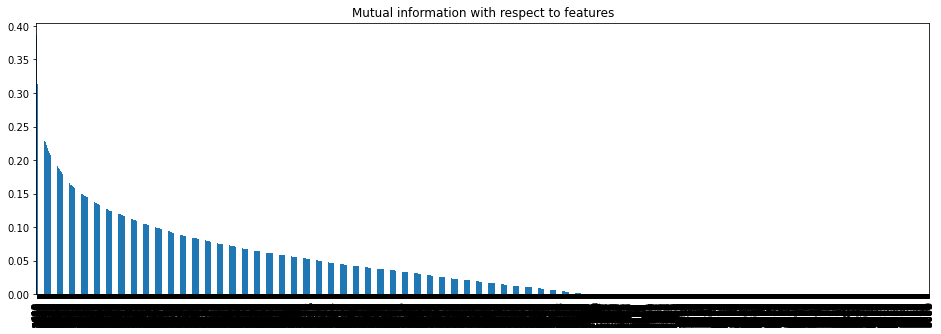

In [ ]:
plt.title('Mutual information with respect to features')
mi.plot.bar(figsize = (16,5))
plt.show()

In [ ]:
sel = SelectPercentile(mutual_info_classifier, percentile=10).fit(X_train_unique, y_train)
X_train_unique.columns[sel.get_support()]

Int64Index([   2,    9,   11,   12,   13,   19,   21,   26,   27,   28,
            ...
            1837, 1840, 1844, 1846, 1854, 1857, 1859, 1861, 1862, 6288],
           dtype='int64', length=707)

In [ ]:
len(X_train_unique.columns[sel.get_support()])

707

In [ ]:
X_train_mi = sel.transform(X_train_unique)
X_test_mi = sel.transform(X_test_unique)
X_train_mi.shape

(61, 707)

## Application Of KNN with 3 neighbors(C1)

In [ ]:
%%time
run_knn(X_train_mi, X_test_mi, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9836065573770492
F1-Score: 
0.9887640449438202
Confusion Matrix: 
[[16  0]
 [ 1 44]]
Testing 20% data report::
Accuracy Score: 
0.9375
F1-Score: 
0.962962962962963
Confusion Matrix: 
[[ 2  1]
 [ 0 13]]
CPU times: user 36.3 ms, sys: 4.06 ms, total: 40.4 ms
Wall time: 38 ms


## Application Of SVM (C2)



In [ ]:
%%time
run_svm(X_train_mi, X_test_mi, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9672131147540983
F1-Score: 
0.9772727272727273
Confusion Matrix: 
[[16  0]
 [ 2 43]]
Testing 20% data report::
Accuracy Score: 
0.9375
F1-Score: 
0.962962962962963
Confusion Matrix: 
[[ 2  1]
 [ 0 13]]
CPU times: user 36.3 ms, sys: 1.08 ms, total: 37.4 ms
Wall time: 36.5 ms


## Task A.2: Application of F Classifier based feature selection(f2)

In [ ]:
#Functions for F classifier 
def f_oneway(*args):
    n_classes = len(args)
    args = [as_float_array(a) for a in args]
    n_samples_per_class = np.array([a.shape[0] for a in args])
    n_samples = np.sum(n_samples_per_class)
    ss_alldata = sum(safe_sqr(a).sum(axis=0) for a in args)
    sums_args = [np.asarray(a.sum(axis=0)) for a in args]
    square_of_sums_alldata = sum(sums_args) ** 2
    square_of_sums_args = [s ** 2 for s in sums_args]
    sstot = ss_alldata - square_of_sums_alldata / float(n_samples)
    ssbn = 0.
    for k, _ in enumerate(args):
        ssbn += square_of_sums_args[k] / n_samples_per_class[k]
    ssbn -= square_of_sums_alldata / float(n_samples)
    sswn = sstot - ssbn
    dfbn = n_classes - 1
    dfwn = n_samples - n_classes
    msb = ssbn / float(dfbn)
    msw = sswn / float(dfwn)
    constant_features_idx = np.where(msw == 0.)[0]
    f = msb / msw #High variance upon low variance 
    # flatten matrix to vector in sparse case
    f = np.asarray(f).ravel()
    prob = special.fdtrc(dfbn, dfwn, f)
    return f, prob


def f_classif(X, y):
    X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'])
    args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
    return f_oneway(*args)

In [ ]:
fc= f_classif(X_train, y_train) 
len(mi)

7070

In [ ]:
fc[: 10]

(array([1.86599787, 2.71660408, 0.66495707, ..., 0.32488098, 0.97306399,
        0.67826326]),
 array([0.17711867, 0.10462485, 0.41809516, ..., 0.57085316, 0.3279454 ,
        0.41350211]))

In [ ]:
#from sklearn.feature_selection import chi2, f_classif
fvalue_selector = SelectPercentile(f_classif, percentile = 10)

In [ ]:
features_kbest = fvalue_selector.fit_transform(X_train_unique, y_train)

In [ ]:
X_train_fc = fvalue_selector.transform(X_train_unique)
X_test_fc = fvalue_selector.transform(X_test_unique)
X_train_fc.shape

(61, 707)

## Application Of KNN (C1)

In [ ]:
%%time
run_knn(X_train_fc, X_test_fc, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9672131147540983
F1-Score: 
0.9772727272727273
Confusion Matrix: 
[[16  0]
 [ 2 43]]
Testing 20% data report::
Accuracy Score: 
0.9375
F1-Score: 
0.9600000000000001
Confusion Matrix: 
[[ 3  0]
 [ 1 12]]
CPU times: user 37 ms, sys: 1.08 ms, total: 38.1 ms
Wall time: 36.5 ms


## Application Of SVM (C2)

In [ ]:
%%time
run_svm(X_train_fc, X_test_fc, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9672131147540983
F1-Score: 
0.9772727272727273
Confusion Matrix: 
[[16  0]
 [ 2 43]]
Testing 20% data report::
Accuracy Score: 
0.9375
F1-Score: 
0.9600000000000001
Confusion Matrix: 
[[ 3  0]
 [ 1 12]]
CPU times: user 38.3 ms, sys: 2.05 ms, total: 40.3 ms
Wall time: 39.3 ms


## Task A.3: Application of T test based feature selection(f3)

In [ ]:
#Functions for  t-test 
import math
def t_oneway(*args):
    n_classes = len(args)
    args = [as_float_array(a) for a in args]
    n_samples_per_class = np.array([a.shape[0] for a in args])
    n_samples = np.sum(n_samples_per_class)
    ss_alldata = sum(safe_sqr(a).sum(axis=0) for a in args)
    sums_args = [np.asarray(a.sum(axis=0)) for a in args]
    square_of_sums_alldata = sum(sums_args) ** 2
    square_of_sums_args = [s ** 2 for s in sums_args]
    sstot = ss_alldata - square_of_sums_alldata / float(n_samples)
    ssbn = 0.
    for k, _ in enumerate(args):
        ssbn += square_of_sums_args[k] / n_samples_per_class[k]
    ssbn -= square_of_sums_alldata / float(n_samples)
    sswn = sstot - ssbn
    dfbn = n_classes - 1
    dfwn = n_samples - n_classes
    msb = ssbn / float(dfbn)
    msw = sswn / float(dfwn)
    constant_features_idx = np.where(msw == 0.)[0]
    t = (ssbn-sswn)**2/ (msb+msw) #Taking sqrt of t value instead of absolute as t due to limitation of numpy. t^2= (absolute differences of means/sum of variances)^2
    # flatten matrix to vector in sparse case
    t = np.asarray(t).ravel()
    prob = special.fdtrc(dfbn, dfwn, t)
    return t, prob


def t_test(X, y):
    X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'])
    args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
    return t_oneway(*args)

In [ ]:
tt= t_test(X_train, y_train) 
len(tt)

2

In [ ]:
tt[: 10]

(array([2.96084110e+07, 1.89911571e+07, 9.28682629e+08, ...,
        1.84427939e+08, 9.96089617e+07, 1.72028268e+08]),
 array([7.04754182e-170, 3.44748233e-164, 5.04337723e-214, ...,
        2.58771365e-193, 2.01835523e-185, 2.01655147e-192]))

In [ ]:
#from sklearn.feature_selection import chi2, f_classif
tvalue_selector = SelectPercentile(t_test, percentile = 10)

In [ ]:
featurestt_kbest = tvalue_selector.fit_transform(X_train_unique, y_train)

In [ ]:
X_train_t = tvalue_selector.transform(X_train_unique)
X_test_t = tvalue_selector.transform(X_test_unique)
X_train_t.shape

(61, 707)

## Application Of KNN (C1)

In [ ]:
%%time
run_knn(X_train_t, X_test_t, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.9344262295081968
F1-Score: 
0.9534883720930233
Confusion Matrix: 
[[16  0]
 [ 4 41]]
Testing 20% data report::
Accuracy Score: 
0.8125
F1-Score: 
0.8695652173913044
Confusion Matrix: 
[[ 3  0]
 [ 3 10]]
CPU times: user 39.1 ms, sys: 5.05 ms, total: 44.1 ms
Wall time: 41.4 ms


## Application Of SVM (C2)

In [ ]:
%%time
run_svm(X_train_t, X_test_t, y_train, y_test)

Training 80% data report::
Accuracy Score: 
0.7704918032786885
F1-Score: 
0.8653846153846153
Confusion Matrix: 
[[ 2 14]
 [ 0 45]]
Testing 20% data report::
Accuracy Score: 
0.8125
F1-Score: 
0.896551724137931
Confusion Matrix: 
[[ 0  3]
 [ 0 13]]
CPU times: user 40.6 ms, sys: 3.06 ms, total: 43.7 ms
Wall time: 42.2 ms


### End of Task A